<a href="https://colab.research.google.com/github/rsdtinfo01/ChemLLM/blob/master/Thangarasu_Dhanabal_NLP_Assignment3_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Author            : Thangarasu Dhanabal
### Subject           : AI 574 Natural Language Processing (2025)
### Code Reviewed by  : Dr. Satish Mahadevan Srinivasan
### Assignment        : Assignment 3 - Sentiment analyzer with BERT and the Transformers library developed by Hugging Face

In [ ]:
#Sentiment Analysis with BERT
#In this assignment we would like to build a sentiment analyzer with BERT and the Transformers library developed by Hugging Face (https://huggingface.co/modelsLinks to an external site.). We will use the Stanford Sentiment Treebank dataset (train.txt Download train.txtand dev.txt Download dev.txt)
#In the Transformers library, the pretrained models are specified by their names, for example the cased BERT-base model ('bert-base-cased') is specified by a constant as follows:
#      BERT_MODEL = 'bert-base-cased'
#Guidelines
#Check the documentation of Hugging Face: (https://huggingface.co/transformers/pretrained_models.html)Links to an external site..
#Build the sentiment analyzer with BERT (transfer learning).
#Write your code and save your Jupyter notebook as [FirstName - LastName]- Assignement3.ipynb
#Export/Print your Jupyter Notebook as pdf.
#Upload both your Jupyter notebook (.ipynb) and its printout (.pdf).

In [ ]:
# Assignment Highlights
# I have used google colab to train hugging face BERT model by using stanford dataset
# Step 1: Installed nessaray softwares in colab
# Step 2: Enbaled GPU
# Step 3:  Data Load
#Step 4: Data preprocessed and ensured quality data from tree to plottted CSV for model training
# Step 5: Data preprocess and agumentation
# Step 6: Hugging face BERT model build and training using Trainer module
# Step 7: Model Evalutaion to get accuracy score , classfication report and confusion metrix
# Step 8 : Model Interpretation to validate the model -with 50% accurary gave perefct result :)
# Step 9 :  Save the model
# Step 10: download the model from colab
# Step 11: Conclusion

In [ ]:
#Install library
#!pip install pandas
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#!python -m textblob.download_corpora
#!pip install contractions textblob wordcloud seaborn matplotlib pandas
import sys

if "google.colab" in sys.modules:
    from google.colab import files
    uploaded = files.upload()  # Select both train.txt and dev.txt
else:
    print("Not running on Colab")


Saving dev.txt to dev.txt
Saving train.txt to train.txt


In [ ]:
import torch
print(" GPU Available!" if torch.cuda.is_available() else " GPU not available.")


 GPU Available!


In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

# Setup Run time environment i will train the dataset using colab
import os
os.environ["ENV"] = "colab"  # or "colab"
# File paths for dataset
train_file_path = "train.txt"
dev_file_path = "dev.txt"

#Load the Data Set  and convert the Dataset into CSV for readability and trainging
# This method REX used to extarct the extact daat from line


def extract_label_and_text(line):
    import re

    def extract_words(tree_str):
        # Extract only the leaf words from the nested structure
        return re.findall(r'\([^()]*? ([^ \s()]+)\)', tree_str)

    label_match = re.match(r"\((\d)", line.strip())
    label = int(label_match.group(1)) if label_match else -1
    words = extract_words(line)
    text = ' '.join(words)
    return text, label



# Build 2D array to store Train text and lables
train_texts, train_labels = [], []
with open(train_file_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            text, label = extract_label_and_text(line)
            train_texts.append(text)
            train_labels.append(label)
# Convert data into CSV for better reading
pd.set_option('display.max_colwidth', None)

pd.DataFrame({"text": train_texts, "label": train_labels}).to_csv("sst_train.csv", index=False)

# Build 2D array to stroe dev text and lables
val_texts, val_labels = [], []
with open(dev_file_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            text, label = extract_label_and_text(line)
            val_texts.append(text)
            val_labels.append(label)
# Convert data into CSV for better reading
pd.DataFrame({"text": val_texts, "label": val_labels}).to_csv("sst_dev.csv", index=False)

# Dispaly Training Data Sample

df = pd.read_csv("sst_train.csv")
HTML(df.head().to_html(index=False))
# check the Dev data set to ensure the tree based data set processed proerly


text,label
"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",3
The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .,4
"Singer\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .",3
You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .,2
Yet the act is still charming here .,3


In [ ]:
# check the Dev data set to ensure the tree based data set processed proerly
print("Test Data")
df_dev = pd.read_csv("sst_dev.csv")
HTML(df_dev.head().to_html(index=False))

Test Data


text,label
It 's a lovely film with lovely performances by Buy and Accorsi .,3
"No one goes unindicted here , which is probably for the best .",2
"And if you 're not nearly moved to tears by a couple of scenes , you 've got ice water in your veins .",3
"A warm , funny , engaging film .",4
"Uses sharp humor and insight into human nature to examine class conflict , adolescent yearning , the roots of friendship and sexual identity .",4


In [ ]:
# Preprocessing the data set to apply basic text cleaning process
import string
import contractions
#fxing contractions apply lower case and removing punctuation
def clean_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Remove duplicates before TRAIN model
df.drop_duplicates(subset='text', inplace=True)

# cleaning to text and add a addtional column in the dataset
df['clean_text'] = df['text'].apply(clean_text)
df['length_clean'] = df['clean_text'].apply(lambda x: len(x.split()))

# Optional: update text used in modeling
text_column_cleaned = 'clean_text'

# Load dev data for evaluation
df_dev['text'] = df_dev['text'].apply(clean_text)

# Assign train and dev sets
train_df = pd.DataFrame({'text': df[text_column_cleaned], 'label': df['label']})
val_df = pd.DataFrame({'text': df_dev['text'], 'label': df_dev['label']})

if os.environ.get("ENV", "local") == "local":
    train_df = train_df.sample(n=100, random_state=42).reset_index(drop=True)
    val_df = val_df.sample(n=20, random_state=42).reset_index(drop=True)
    print("Using sample data for local development")


# check the Cleaned tain data set to ensure the tree based data set processed proerly
print("Cleaned Data")
HTML(train_df.head().to_html(index=False))

Cleaned Data


text,label
the rock is destined to be the 21st century s new conan and that he s going to make a splash even greater than arnold schwarzenegger jeanclaud van damme or steven segal,3
the gorgeously elaborate continuation of the lord of the rings trilogy is so huge that a column of words can not adequately describe cowriterdirector peter jackson s expanded vision of jrr tolkien s middleearth,4
singercomposer bryan adams contributes a slew of songs a few potential hits a few more simply intrusive to the story but the whole package certainly captures the intended er spirit of the piece,3
you would think by now america would have had enough of plucky british eccentrics with hearts of gold,2
yet the act is still charming here,3


In [ ]:
# check the Cleaned dev data set to ensure the tree based data set processed proerly
print("Cleaned Data")
HTML(val_df.head().to_html(index=False))

Cleaned Data


text,label
it s a lovely film with lovely performances by buy and accorsi,3
no one goes unindicted here which is probably for the best,2
and if you are not nearly moved to tears by a couple of scenes you ve got ice water in your veins,3
a warm funny engaging film,4
uses sharp humor and insight into human nature to examine class conflict adolescent yearning the roots of friendship and sexual identity,4


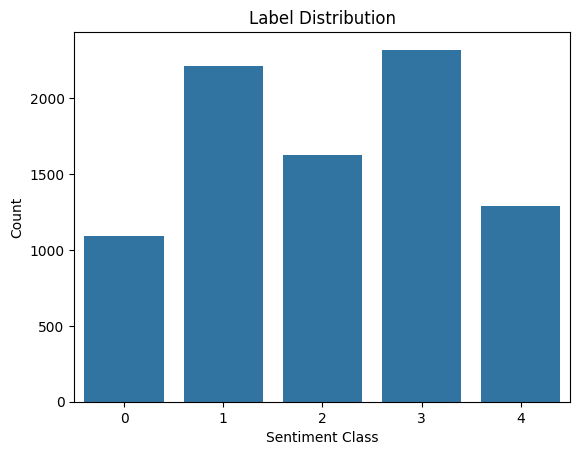

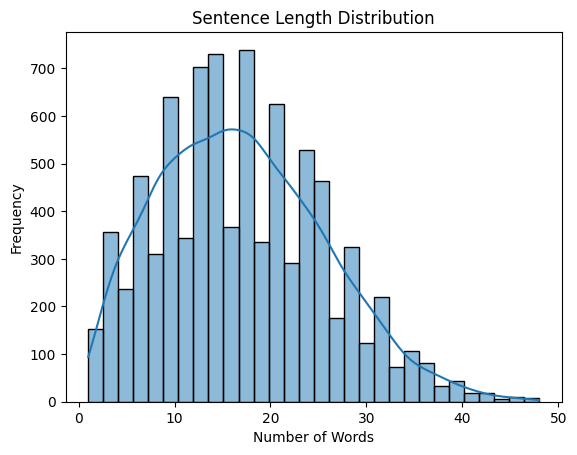

In [ ]:
#  Exploration and analyzie the data set
from textblob import TextBlob
from collections import defaultdict
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# Lets find the Label Distribution
sns.countplot(x='label', data=train_df)
plt.title("Label Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()


# Sentence Length Distribution
train_df['length'] = train_df['text'].apply(lambda x: len(x.split()))
sns.histplot(train_df['length'], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Top TF-IDF words for label 0:
          word       score
11       movie  137.503707
6         film   99.023179
12          nt   70.546095
8         like   55.953798
0          bad   47.319798
7         just   39.998957
16       story   32.183623
2       comedy   31.208404
17        time   27.256629
1   characters   26.582757
Top TF-IDF words for label 1:
          word       score
6         film  204.697216
13       movie  201.959356
14          nt  164.648482
9         like  143.102744
8         just   81.874565
5         does   76.280469
18       story   69.157435
17         rrb   60.195766
11         lrb   59.342048
3   characters   58.013734
Top TF-IDF words for label 2:
     word       score
4    film  166.313461
13  movie  125.163998
15     nt   97.260828
8    like   71.082614
17  story   49.345268
11    lrb   41.024611
3    does   40.677523
16    rrb   40.470578
6    good   39.790572
7    just   38.550405
Top TF-IDF words for label 3:
     word       score
4    film  263.899275


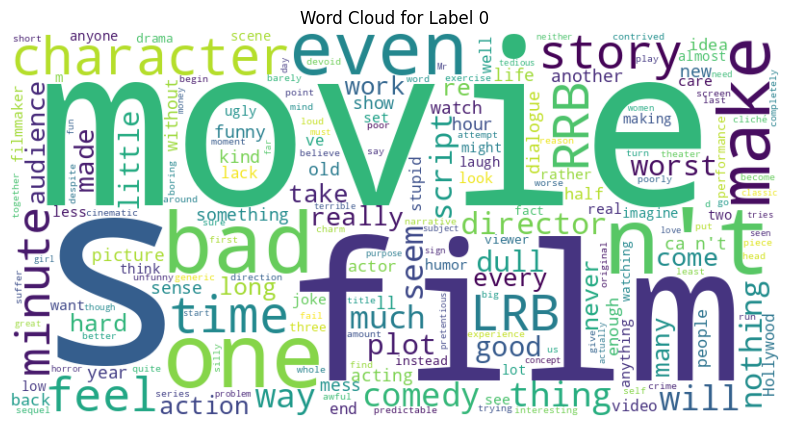

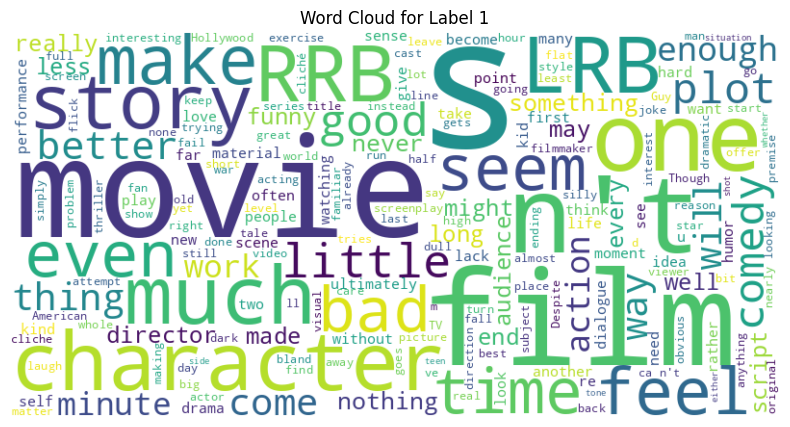

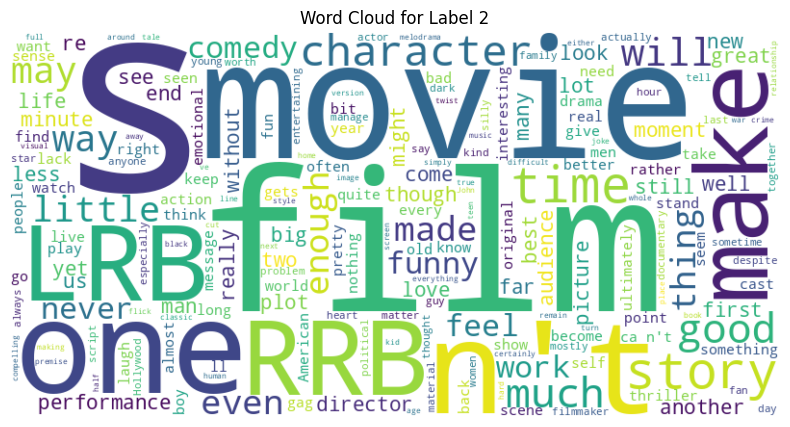

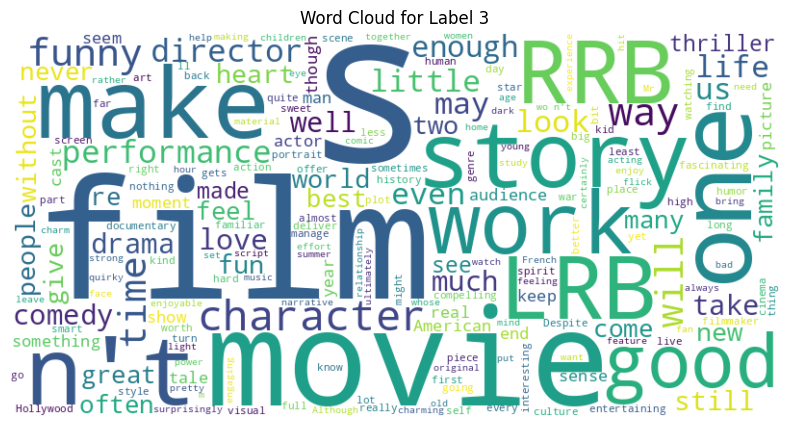

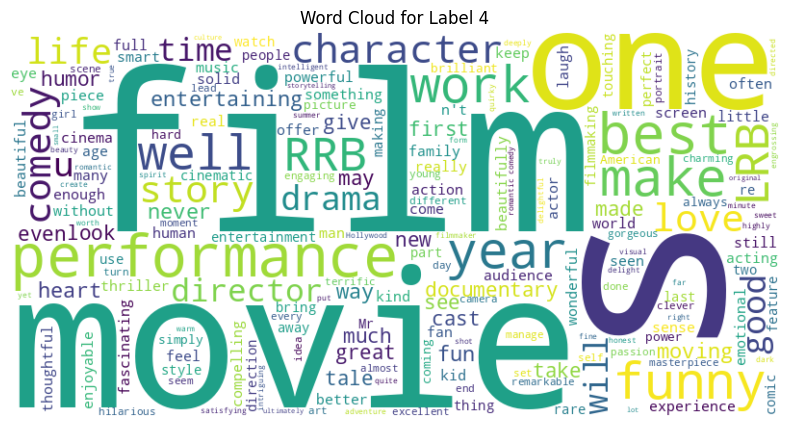

In [ ]:
# TF-IDF Top Words per Class
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['text']
    vec = TfidfVectorizer(stop_words='english', max_features=20)
    tfidf_matrix = vec.fit_transform(subset)
    words = vec.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    tfidf_df = pd.DataFrame({'word': words, 'score': scores}).sort_values(by='score', ascending=False)
    print(f"Top TF-IDF words for label {label}:")
    print(tfidf_df.head(10))

# Word Cloud per Sentiment Label
for label in sorted(df['label'].unique()):
    text = " ".join(df[df['label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Label {label}")
    plt.show()

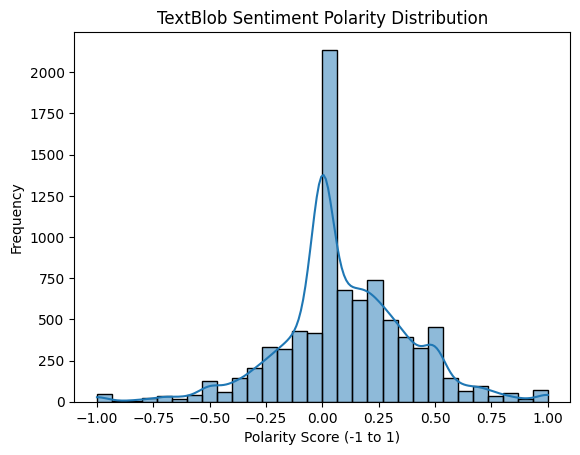

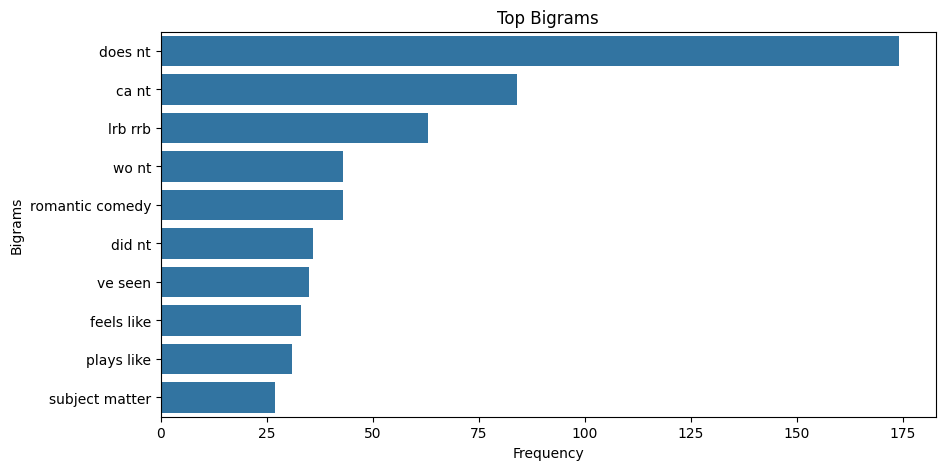

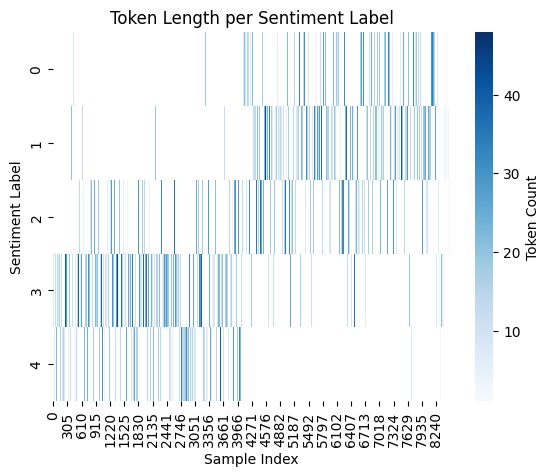

In [ ]:

# Sentiment Polarity using TextBlob
polarity_scores = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['polarity'] = polarity_scores
sns.histplot(train_df['polarity'], bins=30, kde=True)
plt.title("TextBlob Sentiment Polarity Distribution")
plt.xlabel("Polarity Score (-1 to 1)")
plt.ylabel("Frequency")
plt.show()

# N-gram Frequency Plot (Bigrams)
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_ngrams = words_freq[:n]
    x, y = zip(*top_ngrams)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(y), y=list(x))
    plt.title("Top Bigrams")
    plt.xlabel("Frequency")
    plt.ylabel("Bigrams")
    plt.show()

plot_top_ngrams(train_df['text'], ngram_range=(2, 2), n=10)

# Token Length Heatmap per Class
heatmap_data = defaultdict(list)
for label in sorted(train_df['label'].unique()):
    lengths = train_df[train_df['label'] == label]['text'].apply(lambda x: len(x.split()))
    heatmap_data[label] = lengths

heatmap_df = pd.DataFrame(dict(heatmap_data))
sns.heatmap(heatmap_df.T, cmap='Blues', cbar_kws={'label': 'Token Count'})
plt.title("Token Length per Sentiment Label")
plt.xlabel("Sample Index")
plt.ylabel("Sentiment Label")
plt.show()

In [ ]:
# BUild BERT model from Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

BERT_MODEL = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)


train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=5)

fp16 = torch.cuda.is_available()
print(model)
# Now model is ready to trian , lets do train using huggingface trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    fp16=fp16  # Works only with GPU
)



Map:   0%|          | 0/8534 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-733cba2498c4>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# to get accuracy metrics
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"eval_accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



<ipython-input-25-411b75209e3d>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thangarasudhanabal (thangarasudhanabal-penn-state) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.177800,1.187858
2,0.887700,1.179771
3,0.623500,1.376397


TrainOutput(global_step=3201, training_loss=0.9299588523705056, metrics={'train_runtime': 534.8089, 'train_samples_per_second': 47.871, 'train_steps_per_second': 5.985, 'total_flos': 1684087670840832.0, 'train_loss': 0.9299588523705056, 'epoch': 3.0})

Validation Accuracy: 0.5095
Classification Report:
              precision    recall  f1-score   support

           0     0.5082    0.4460    0.4751       139
           1     0.5629    0.5882    0.5753       289
           2     0.4032    0.3275    0.3614       229
           3     0.5032    0.5663    0.5329       279
           4     0.5424    0.5818    0.5614       165

    accuracy                         0.5095      1101
   macro avg     0.5040    0.5020    0.5012      1101
weighted avg     0.5046    0.5095    0.5053      1101



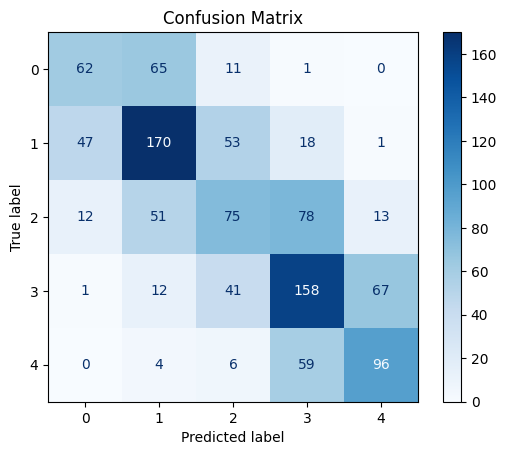

In [ ]:
#Evaluation  the model
#  Evaluation and Interpretation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
eval_results = trainer.evaluate()

print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")

# Classification Report
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
print("Classification Report:")
print(classification_report(labels, preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save Model and Tokenizer
model.save_pretrained("bert_sentiment_model")
tokenizer.save_pretrained("bert_sentiment_model")



('bert_sentiment_model/tokenizer_config.json',
 'bert_sentiment_model/special_tokens_map.json',
 'bert_sentiment_model/vocab.txt',
 'bert_sentiment_model/added_tokens.json',
 'bert_sentiment_model/tokenizer.json')

In [ ]:
# Example Inference
text = "The movie was absolutely fantastic!"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Move to same device as model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run model
outputs = model(**inputs)
pred_label = outputs.logits.argmax(dim=1).item()

print(f"Predicted sentiment label: {pred_label}")
# this is excellet predtict , but we have accuracy score only 50% , so this trained model would have give correct predcition

Predicted sentiment label: 4


In [ ]:
import shutil
shutil.make_archive("bert_sentiment_model", 'zip', "bert_sentiment_model")

from google.colab import files
files.download("bert_sentiment_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title
print("Conclusion ")
#Conclusion
#Overall is alidation accuracy of ~50.95%, which is slightly better than random chance(20%)
#Classification Report Precision, Recall, F1-Scores hover around 50–58% across all classes
#The performance is relatively balanced, with no extreme bias toward any single class
#Confusion Matrix Observations- It looks like model struggles to differentiate closely related sentiments
#Inference Prediction- The test input "The movie was absolutely fantastic!"
#predicted label 4, which is correct for a strongly positive sentiment
#Model Quality - 50% is not good score , so we need to finetune this model with hyper parameter
#and other adjustment (increase epoch, adjust learning rate and batch size) would increse score.

Conclusion 
